In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

Períodos com maior potência (horas) — limitados a 720 h:
 - 24.00 h (power=7.059e+00)
 - 24.02 h (power=1.749e+00)
 - 23.98 h (power=1.634e+00)
 - 12.00 h (power=3.859e-01)
 - 710.92 h (power=3.475e-01)
 - 641.56 h (power=3.369e-01)
Período dominante detectado: 24.00 h


C:\Users\Eduardo\AppData\Local\Temp\ipykernel_11148\3007086617.py:37: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  series = series.asfreq('H')
C:\Users\Eduardo\AppData\Local\Temp\ipykernel_11148\3007086617.py:55: RuntimeWarning: divide by zero encountered in divide
  period_hours = np.where(mask, 1.0 / f, np.nan)


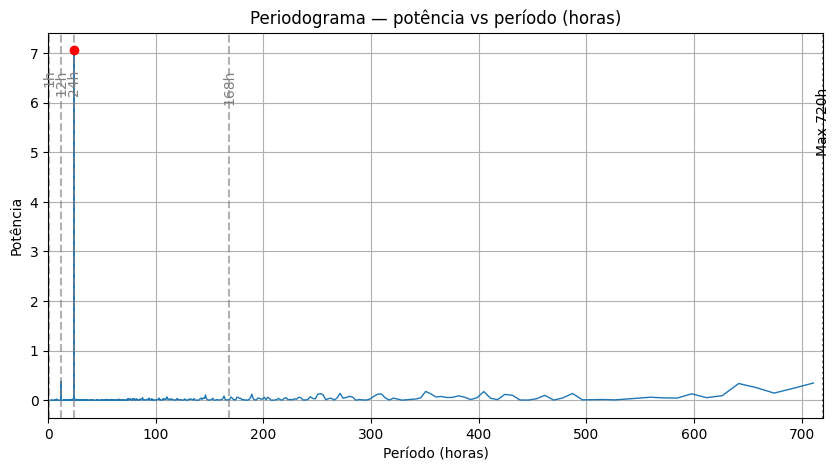

In [ ]:
# --- Gerar features que serão usadas no modelo ---
import sys, os
sys.path.append(os.path.abspath('..'))
from pre_processamento.processamento_dados import processamento
# --- Importações auxiliares ---
from sklearn.preprocessing import StandardScaler
import numpy as np

# Carrega dados e cria colunas de tempo
df = processamento()
# Gerar colunas 'hora' e 'mes' a partir do índice datetime
df['hora'] = df.index.hour
df['mes'] = df.index.month

# --- Termos de Fourier para periodicidade horária (período = 24 horas) ---
def add_fourier_terms(df, period_hours=24, n_harmonics=3, prefix='fourier'):
    """Adiciona colunas sin/cos para os n_harmonics primeiros harmônicos.
    Usa horas desde o primeiro timestamp como base de tempo."""
    t = (df.index - df.index[0]).total_seconds() / 3600.0
    t = np.asarray(t)
    for k in range(1, n_harmonics + 1):
        df[f'{prefix}_{k}_sin'] = np.sin(2 * np.pi * k * t / period_hours)
        df[f'{prefix}_{k}_cos'] = np.cos(2 * np.pi * k * t / period_hours)
    return df

# Adiciona 3 harmônicos por padrão (pode ajustar se necessário)
df = add_fourier_terms(df, period_hours=24, n_harmonics=3)

# Lista de colunas de Fourier criadas
fourier_cols = [c for c in df.columns if c.startswith('fourier_')]

# --- Criar conjuntos de treino / validação / teste (por períodos) ---
# Período de treino (2010)
train_end = '2010-12-31 23:00:00'
feature_cols = ['hora', 'mes'] + fourier_cols
X_train = df[feature_cols].loc[:train_end]
y_train = df['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].loc[:train_end]

# Período de validação (2011)
val_end = '2011-12-31 23:00:00'
val_start = '2011-01-01 00:00:00'
X_val = df[feature_cols].loc[val_start:val_end]
y_val = df['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].loc[val_start:val_end]

# Período de teste (2012)
test_start = '2012-01-01 00:00:00'
X_test = df[feature_cols].loc[test_start:]
y_test = df['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].loc[test_start:]


In [ ]:
# Calcula e plota periodograma (usa scipy se disponível, senão FFT)
try:
    target = 'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'
    series = df[target].dropna()
    series = series.asfreq('H')
    y = series.values
    n = len(y)
    fs = 1.0  # amostras por hora

    # Período máximo a analisar (em horas). Ajuste conforme desejado (ex.: 720 = 30 dias)
    max_period_hours = 720

    try:
        from scipy import signal
        f, Pxx = signal.periodogram(y - np.mean(y), fs=fs, window='hann', scaling='spectrum', detrend='linear')
    except Exception:
        Y = np.fft.rfft(y - np.mean(y))
        Pxx = (np.abs(Y) ** 2) / n
        f = np.fft.rfftfreq(n, d=1.0/fs)

    # Converter frequência -> período (horas), ignorando f=0
    mask = f > 0
    period_hours = np.where(mask, 1.0 / f, np.nan)
    import pandas as pd
    df_per = pd.DataFrame({'freq': f[mask], 'power': Pxx[mask], 'period_hours': period_hours[mask]})
    df_per = df_per.sort_values('period_hours')

    # Filtrar períodos até o máximo desejado para análise/plot
    df_per_visible = df_per[df_per['period_hours'] <= max_period_hours]
    if df_per_visible.empty:
        df_per_visible = df_per.copy()

    # Imprime principais períodos dentro da faixa analisada
    topk = df_per_visible.nlargest(6, 'power')
    print("Períodos com maior potência (horas) — limitados a", max_period_hours, "h:")
    for _, row in topk.iterrows():
        print(f" - {row['period_hours']:.2f} h (power={row['power']:.3e})")

    # Detecta pico dominante (opcional, usa scipy if available)
    dominant_period = None
    try:
        from scipy.signal import find_peaks
        peaks, props = find_peaks(df_per_visible['power'].values, prominence=(df_per_visible['power'].max() * 0.05))
        if len(peaks) > 0:
            idx = peaks[np.argmax(df_per_visible['power'].values[peaks])]
            dominant_period = df_per_visible['period_hours'].values[idx]
    except Exception:
        if not df_per_visible.empty:
            dominant_period = df_per_visible.nlargest(1, 'power')['period_hours'].values[0]

    if dominant_period is not None:
        print(f"Período dominante detectado: {dominant_period:.2f} h")

    # Plot: potência vs período (horas)
    plt.figure(figsize=(10, 5))
    plt.plot(df_per_visible['period_hours'], df_per_visible['power'], lw=1)
    plt.xlim(0, max_period_hours)
    plt.xlabel('Período (horas)')
    plt.ylabel('Potência')
    plt.title('Periodograma — potência vs período (horas)')
    # linhas guias para períodos interessantes
    for ph in [1, 12, 24, 168]:
        if ph <= max_period_hours:
            plt.axvline(ph, color='gray', linestyle='--', alpha=0.6)
            plt.text(ph, plt.ylim()[1]*0.9, str(ph)+'h', rotation=90, va='top', ha='center', color='gray')
    # marca o limite máximo de análise
    plt.axvline(max_period_hours, color='black', linestyle=':', alpha=0.5)
    plt.text(max_period_hours, plt.ylim()[1]*0.85, f'Max {max_period_hours}h', rotation=90, va='top', ha='center')
    if dominant_period is not None:
        plt.scatter([dominant_period], [df_per_visible.loc[df_per_visible['period_hours']==dominant_period, 'power'].values[0]], color='red', zorder=5)
    plt.grid(True)
    plt.show()
except Exception as e:
    print('Falha ao gerar periodograma:', e)

In [18]:
X_train.head()

,hora,mes
DATETIME,,
2010-01-01 00:00:00,0,1
2010-01-01 01:00:00,1,1
2010-01-01 02:00:00,2,1
2010-01-01 03:00:00,3,1
2010-01-01 04:00:00,4,1


In [12]:
y_train.head()

DATETIME
2010-01-01 00:00:00    21.6
2010-01-01 01:00:00    21.1
2010-01-01 02:00:00    20.8
2010-01-01 03:00:00    20.5
2010-01-01 04:00:00    20.0
Name: TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C), dtype: float64

In [19]:
X_val.head()

,hora,mes
DATETIME,,
2011-01-01 00:00:00,0,1
2011-01-01 01:00:00,1,1
2011-01-01 02:00:00,2,1
2011-01-01 03:00:00,3,1
2011-01-01 04:00:00,4,1



Dados prontos! Agora o Teste contém apenas o período equivalente ao Treino.

=== 4.1 VISUALIZAÇÃO DA SÉRIE TEMPORAL ===


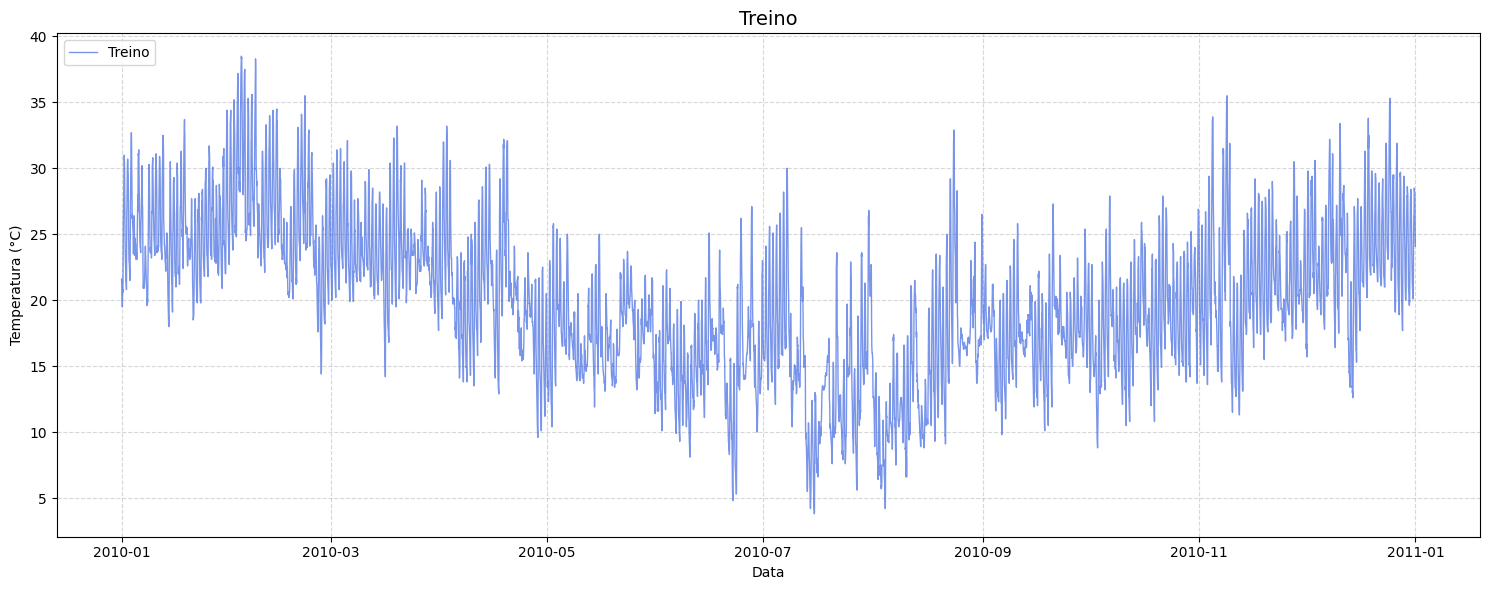

In [8]:
# --- Normalização ---
scaler = StandardScaler()

# Ajustar o scaler apenas no TREINO (evitar vazamento de dados)
X_train_scaled = scaler.fit_transform(X_train)

# Aplicar o scaler em Validação e Teste
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Converter de volta para DataFrame para preservar índices e nomes de colunas
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index)




In [9]:
# --- Checagem preliminar: é apropriado usar intervalos de previsão empíricos? ---
# Heurística: verificar tamanho da série, missing, estacionariedade, autocorrelação,
# heteroscedasticidade e presença de outliers.

target = 'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'
series = df[target].dropna()

n = len(series)
pct_missing = df[target].isna().mean()
unique_vals = series.nunique()

print(f"\n-- Pré-checagem para uso de PIs empíricos na série '{target}' --")
print(f"Tamanho da série (n): {n}")
print(f"Percentual de missing: {pct_missing:.2%}")
print(f"Valores únicos: {unique_vals}")

# Estatísticas de outliers
s_mean = series.mean()
s_std = series.std()
pct_outliers = ((series - s_mean).abs() > 3 * s_std).mean()
print(f"Percentual de outliers (>3σ): {pct_outliers:.2%}")

# Rolling std para avaliar heteroscedasticidade
rolling_std = series.rolling(window=24, min_periods=12).std()
if rolling_std.dropna().empty:
    std_cv = np.nan
else:
    std_cv = rolling_std.std() / (rolling_std.mean() if rolling_std.mean() != 0 else np.nan)
print(f"Coeficiente de variação da volatilidade (rolling std CV): {std_cv:.3f}")

# Testes ADF e ACF (se statsmodels disponível)
adf_p = None
acf_info = None
try:
    from statsmodels.tsa.stattools import adfuller, acf
    # ADF
    try:
        adf_res = adfuller(series)
        adf_stat, adf_p = adf_res[0], adf_res[1]
        print(f"ADF stat: {adf_stat:.3f}, p-value: {adf_p:.4f}")
    except Exception as e:
        print(f"Falha ao rodar ADF: {e}")
    # ACF
    try:
        acf_vals = acf(series, nlags=min(72, max(24, int(n/10))), fft=False)
        strong_acf = np.sum(np.abs(acf_vals[1:]) > 0.2)
        print(f"Autocorrelações |ACF|>0.2 nos primeiros lags: {strong_acf}")
        acf_info = acf_vals
    except Exception as e:
        print(f"Falha ao calcular ACF: {e}")
except Exception:
    print('statsmodels não disponível. Instale via `pip install statsmodels` para ADF/ACF.')

# --- Decisão heurística (orientativa) ---
reasons = []
allow_empirical_pi = True

if n < 200:
    reasons.append('Amostra pequena (n < 200) — quantis empíricos instáveis')
    allow_empirical_pi = False
if pct_missing > 0.05:
    reasons.append('Alto percentual de missing (>5%) — imputar/tratar antes')
    allow_empirical_pi = False
if pct_outliers > 0.02:
    reasons.append('Mais de 2% de outliers (>3σ) — considerar tratamento')
if not np.isnan(std_cv) and std_cv > 0.5:
    reasons.append('Evidência de heteroscedasticidade (rolling std CV alto)')
    allow_empirical_pi = False
if adf_p is not None and adf_p > 0.05:
    reasons.append('Série possivelmente não estacionária (ADF p>0.05) — modelar tendência antes')

if acf_info is not None and np.sum(np.abs(acf_info[1:]) > 0.5) > 0:
    reasons.append('Autocorrelação forte em lags iniciais — resíduos provavelmente correlacionados')

print('\n--- Resumo da pré-checagem ---')
if allow_empirical_pi:
    print('Empirical PI: OK para uso com cautela.')
else:
    print('Empirical PI: NÃO recomendado sem ajustes. Motivos:')
    for r in reasons:
        print(' -', r)

print('\nRecomendações:')
print(' - Se usar PIs empíricos, valide cobertura em holdout e use sliding-window.')
print(' - Alternativas: block-conformal, regressão quantílica, modelos probabilísticos ou bootstrap em blocos.')

pi_precheck = {'allow_empirical_pi': allow_empirical_pi, 'reasons': reasons}



-- Pré-checagem para uso de PIs empíricos na série 'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)' --
Tamanho da série (n): 26304
Percentual de missing: 0.00%
Valores únicos: 368
Percentual de outliers (>3σ): 0.09%
Coeficiente de variação da volatilidade (rolling std CV): 0.376
ADF stat: -8.416, p-value: 0.0000
Autocorrelações |ACF|>0.2 nos primeiros lags: 72

--- Resumo da pré-checagem ---
Empirical PI: OK para uso com cautela.

Recomendações:
 - Se usar PIs empíricos, valide cobertura em holdout e use sliding-window.
 - Alternativas: block-conformal, regressão quantílica, modelos probabilísticos ou bootstrap em blocos.


In [25]:
# --- Modelagem, avaliação e tunagem (TimeSeriesSplit + RandomSearch) ---
print("\n=== 5. MODELAGEM E TUNAGEM (TimeSeriesSplit + RandomSearch) ===")

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, make_scorer
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import randint, uniform

# Concatenar dados de treino e validação para usar TimeSeriesSplit
X_combined = pd.concat([X_train, X_val])
y_combined = pd.concat([y_train, y_val])

print(f"Conjunto combinado (Treino + Validação): {len(X_combined)} amostras")

# Valores de n_splits a testar
n_splits_values = [3, 5, 10]

# Definição de pipelines e distribuições de hiperparâmetros para RandomSearch
models_config = {
    'Random Forest': {
        'pipeline': Pipeline([
            ('scaler', StandardScaler()),
            ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
        ]),
        'param_distributions': {
            'model__n_estimators': randint(50, 1000),
            'model__max_depth': [None, 5, 10, 15, 20, 30, 40, 50],
            'model__min_samples_split': randint(2, 100),
            'model__min_samples_leaf': randint(1, 100),
            'model__max_features': ['sqrt', 'log2', None]
        },
        'n_iter': 100  # número de combinações a testar
    },
    'Gradient Boosting': {
        'pipeline': Pipeline([
            ('scaler', StandardScaler()),
            ('model', GradientBoostingRegressor(random_state=42))
        ]),
        'param_distributions': {
            'model__n_estimators': randint(50, 1000),
            'model__learning_rate': uniform(0.01, 0.3),
            'model__max_depth': randint(2, 100),
            'model__min_samples_split': randint(2, 100),
            'model__min_samples_leaf': randint(1, 100),
            'model__subsample': uniform(0.5, 0.5)
        },
        'n_iter':100  # número de combinações a testar
    }
}

# Métrica de scoring (RMSE negativo para sklearn)
scoring = make_scorer(lambda y_true, y_pred: -np.sqrt(mean_squared_error(y_true, y_pred)))

# Armazenar resultados da tunagem
tuning_results = []
best_per_model = {}

for model_name, config in models_config.items():
    print(f"\n{'='*80}")
    print(f"Tunando {model_name} com RandomSearch")
    print(f"{'='*80}")
    
    pipeline_template = config['pipeline']
    param_distributions = config['param_distributions']
    n_iter = config['n_iter']
    
    best_overall_score = np.inf
    best_overall_config = None
    
    for n_splits in n_splits_values:
        print(f"\n--- n_splits = {n_splits} ---")
        
        # Configurar TimeSeriesSplit
        tscv = TimeSeriesSplit(n_splits=n_splits)
        
        # RandomizedSearchCV: testa n_iter combinações aleatórias
        random_search = RandomizedSearchCV(
            estimator=pipeline_template,
            param_distributions=param_distributions,
            n_iter=n_iter,
            cv=tscv,
            scoring=scoring,
            n_jobs=-1,
            random_state=42,
            verbose=1
        )
        
        # Executar tunagem
        t0 = time.time()
        random_search.fit(X_combined, y_combined)
        tuning_time = time.time() - t0
        
        # Melhor resultado para este n_splits
        best_score = -random_search.best_score_  # converter de volta para RMSE positivo
        best_params = random_search.best_params_
        best_model = random_search.best_estimator_
        
        print(f"\nMelhor RMSE para n_splits={n_splits}: {best_score:.4f}")
        print(f"Melhores hiperparâmetros: {best_params}")
        print(f"Tempo de tunagem: {tuning_time:.2f}s")
        
        # Calcular métricas adicionais com validação cruzada
        cv_scores_rmse = []
        cv_scores_r2 = []
        cv_scores_mae = []
        cv_scores_mape = []
        
        for fold_idx, (train_idx, test_idx) in enumerate(tscv.split(X_combined)):
            X_train_fold = X_combined.iloc[train_idx]
            y_train_fold = y_combined.iloc[train_idx]
            X_test_fold = X_combined.iloc[test_idx]
            y_test_fold = y_combined.iloc[test_idx]
            
            fold_model = random_search.best_estimator_
            fold_model.fit(X_train_fold, y_train_fold)
            y_pred_fold = fold_model.predict(X_test_fold)
            
            cv_scores_rmse.append(np.sqrt(mean_squared_error(y_test_fold, y_pred_fold)))
            cv_scores_r2.append(r2_score(y_test_fold, y_pred_fold))
            cv_scores_mae.append(mean_absolute_error(y_test_fold, y_pred_fold))
            cv_scores_mape.append(mean_absolute_percentage_error(y_test_fold, y_pred_fold) * 100)
        
        # Agregar métricas
        metrics_agg = {
            'rmse_mean': float(np.mean(cv_scores_rmse)),
            'rmse_std': float(np.std(cv_scores_rmse)),
            'r2_mean': float(np.mean(cv_scores_r2)),
            'r2_std': float(np.std(cv_scores_r2)),
            'mae_mean': float(np.mean(cv_scores_mae)),
            'mape_mean': float(np.mean(cv_scores_mape))
        }
        
        # Armazenar resultado
        result = {
            'model': model_name,
            'n_splits': int(n_splits),
            'n_iter_tested': int(n_iter),
            'best_params': best_params,
            'tuning_time_s': float(tuning_time),
            **metrics_agg
        }
        tuning_results.append(result)
        
        # Atualizar melhor configuração global
        if metrics_agg['rmse_mean'] < best_overall_score:
            best_overall_score = metrics_agg['rmse_mean']
            best_overall_config = {
                'n_splits': int(n_splits),
                'best_params': best_params,
                'best_model': best_model,
                'metrics': metrics_agg
            }
    
    # Salvar melhor modelo
    if best_overall_config is not None:
        best_per_model[model_name] = best_overall_config
        print(f"\n{'*'*80}")
        print(f"Melhor configuração para {model_name}:")
        print(f"  n_splits: {best_overall_config['n_splits']}")
        print(f"  RMSE: {best_overall_config['metrics']['rmse_mean']:.4f} ± {best_overall_config['metrics']['rmse_std']:.4f}")
        print(f"  R2:   {best_overall_config['metrics']['r2_mean']:.4f} ± {best_overall_config['metrics']['r2_std']:.4f}")
        print(f"  MAE:  {best_overall_config['metrics']['mae_mean']:.4f}")
        print(f"  MAPE: {best_overall_config['metrics']['mape_mean']:.2f}%")
        print(f"  Hiperparâmetros: {best_overall_config['best_params']}")
        print(f"{'*'*80}\n")

# Mostrar resumo completo da tunagem
df_tuning = pd.DataFrame(tuning_results)
if not df_tuning.empty:
    print("\n=== Resumo Completo da Tunagem (RandomSearch + TimeSeriesSplit) ===")
    display(df_tuning.sort_values(['model', 'rmse_mean']).reset_index(drop=True))

# Resumo dos melhores modelos
print('\n' + '='*80)
print('=== MELHORES CONFIGURAÇÕES FINAIS POR MODELO ===')
print('='*80)
for m, info in best_per_model.items():
    print(f"\n{m}:")
    print(f"  n_splits (melhor): {info['n_splits']}")
    print(f"  RMSE (validação):  {info['metrics']['rmse_mean']:.4f} ± {info['metrics']['rmse_std']:.4f}")
    print(f"  R2 (validação):    {info['metrics']['r2_mean']:.4f} ± {info['metrics']['r2_std']:.4f}")
    print(f"  MAE (validação):   {info['metrics']['mae_mean']:.4f}")
    print(f"  MAPE (validação):  {info['metrics']['mape_mean']:.2f}%")
    print(f"\n  Melhores hiperparâmetros encontrados:")
    for param, value in info['best_params'].items():
        print(f"    - {param}: {value}")

# Nota: RandomizedSearchCV testa n_iter combinações aleatórias de hiperparâmetros
# dentro das distribuições especificadas, mais eficiente que GridSearch para espaços grandes.
# Validação realizada com TimeSeriesSplit para respeitar ordem temporal.



=== 5. MODELAGEM E TUNAGEM (TimeSeriesSplit + RandomSearch) ===
Conjunto combinado (Treino + Validação): 17520 amostras

Tunando Random Forest com RandomSearch

--- n_splits = 3 ---
Fitting 3 folds for each of 100 candidates, totalling 300 fits

Melhor RMSE para n_splits=3: 3.8439
Melhores hiperparâmetros: {'model__max_depth': 50, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 60, 'model__min_samples_split': 8, 'model__n_estimators': 874}
Tempo de tunagem: 90.28s

--- n_splits = 5 ---
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Melhor RMSE para n_splits=5: 4.1444
Melhores hiperparâmetros: {'model__max_depth': 30, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 28, 'model__n_estimators': 682}
Tempo de tunagem: 150.79s

--- n_splits = 10 ---
Fitting 10 folds for each of 100 candidates, totalling 1000 fits

Melhor RMSE para n_splits=10: 3.6607
Melhores hiperparâmetros: {'model__max_depth': 50, 'model__max_features': 

,model,n_splits,n_iter_tested,best_params,tuning_time_s,rmse_mean,rmse_std,r2_mean,r2_std,mae_mean,mape_mean
0,Gradient Boosting,5,100,"{'model__learning_rate': 0.1370204442119109, '...",257.791444,3.535953,0.645348,0.382858,0.203770,2.803851,18.267216
1,Gradient Boosting,10,100,"{'model__learning_rate': 0.18738933631231813, ...",512.648042,3.644996,0.847998,0.293902,0.292559,2.885703,18.443750
2,Gradient Boosting,3,100,"{'model__learning_rate': 0.2239734361668985, '...",157.097272,3.779098,0.884027,0.521036,0.237513,2.972499,19.254971
3,Random Forest,10,100,"{'model__max_depth': 50, 'model__max_features'...",296.236559,3.660681,0.879336,0.284863,0.315243,2.900411,18.538849
4,Random Forest,3,100,"{'model__max_depth': 50, 'model__max_features'...",90.276767,3.843915,0.794898,0.510903,0.219086,3.009584,19.700520
5,Random Forest,5,100,"{'model__max_depth': 30, 'model__max_features'...",150.792460,4.144352,1.283907,0.104697,0.512024,3.273961,20.994987



=== MELHORES CONFIGURAÇÕES FINAIS POR MODELO ===

Random Forest:
  n_splits (melhor): 10
  RMSE (validação):  3.6607 ± 0.8793
  R2 (validação):    0.2849 ± 0.3152
  MAE (validação):   2.9004
  MAPE (validação):  18.54%

  Melhores hiperparâmetros encontrados:
    - model__max_depth: 50
    - model__max_features: None
    - model__min_samples_leaf: 9
    - model__min_samples_split: 20
    - model__n_estimators: 865

Gradient Boosting:
  n_splits (melhor): 5
  RMSE (validação):  3.5360 ± 0.6453
  R2 (validação):    0.3829 ± 0.2038
  MAE (validação):   2.8039
  MAPE (validação):  18.27%

  Melhores hiperparâmetros encontrados:
    - model__learning_rate: 0.1370204442119109
    - model__max_depth: 2
    - model__min_samples_leaf: 8
    - model__min_samples_split: 89
    - model__n_estimators: 112
    - model__subsample: 0.9077307142274171



=== 6. AVALIAÇÃO NO CONJUNTO DE TESTE ===

>>> MODELO SELECIONADO PARA TESTE: Gradient Boosting
>>> RMSE (validação): 3.5360 ± 0.6453
>>> R2 (validação):   0.3829 ± 0.2038
>>> Configuração: n_splits=5

--- Avaliação 1-step ahead no Teste ---
RMSE (Teste):   4.1296
MAE (Teste):    3.2503
MAPE (Teste):   17.95%
R2 (Teste):     0.5486

Intervalos de Previsão Empíricos (95%):
  Quantil inferior (2.5%): -6.3792
  Quantil superior (97.5%): 6.7211
  Coverage (Teste): 0.8879
  Largura média do PI: 13.1002


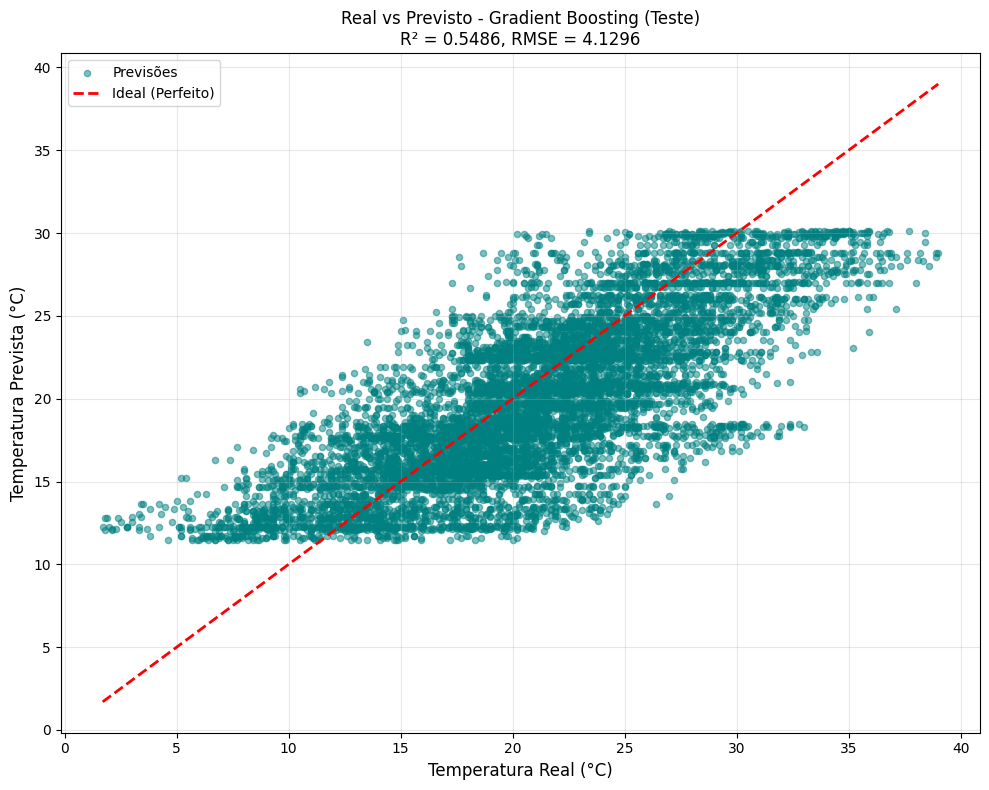

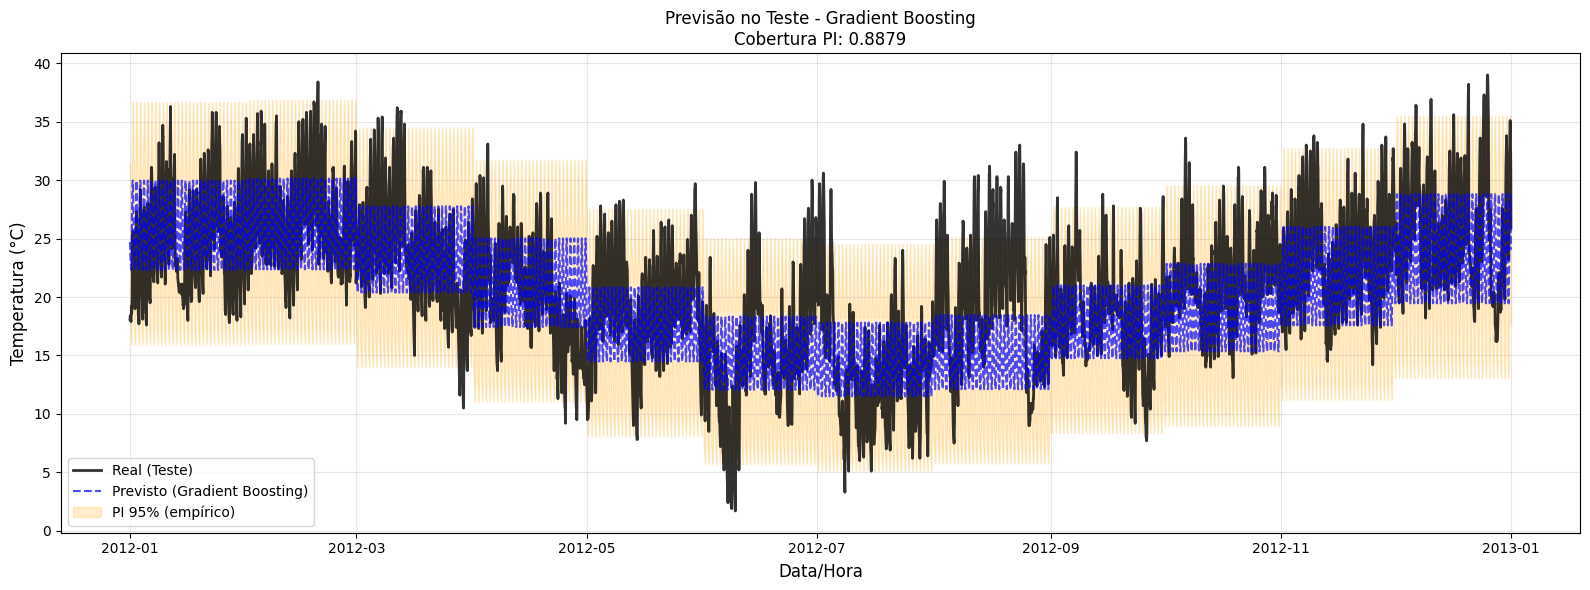

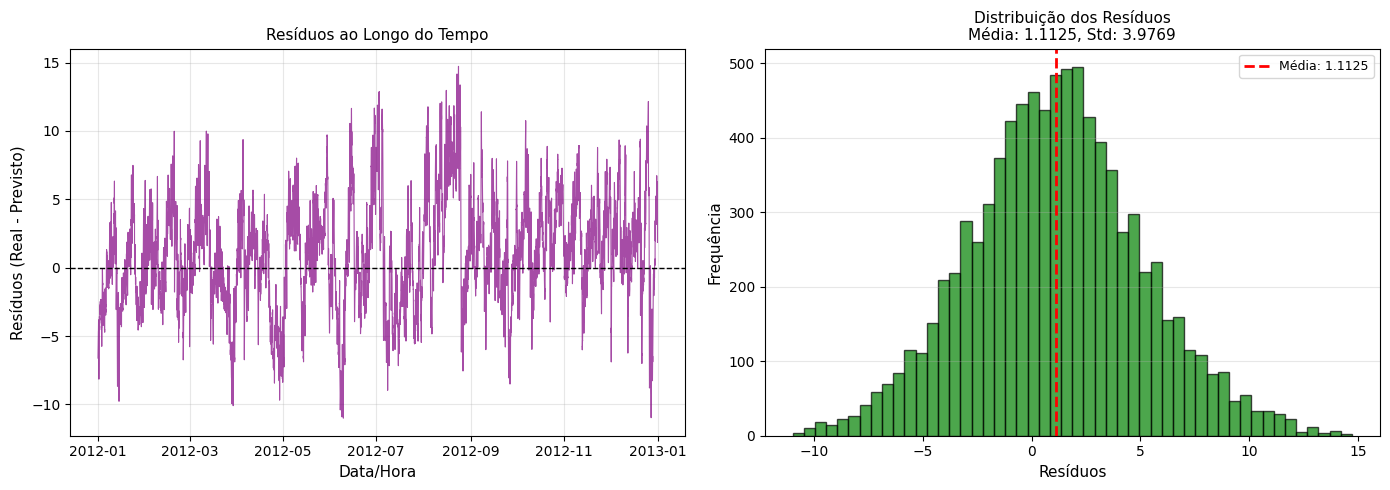

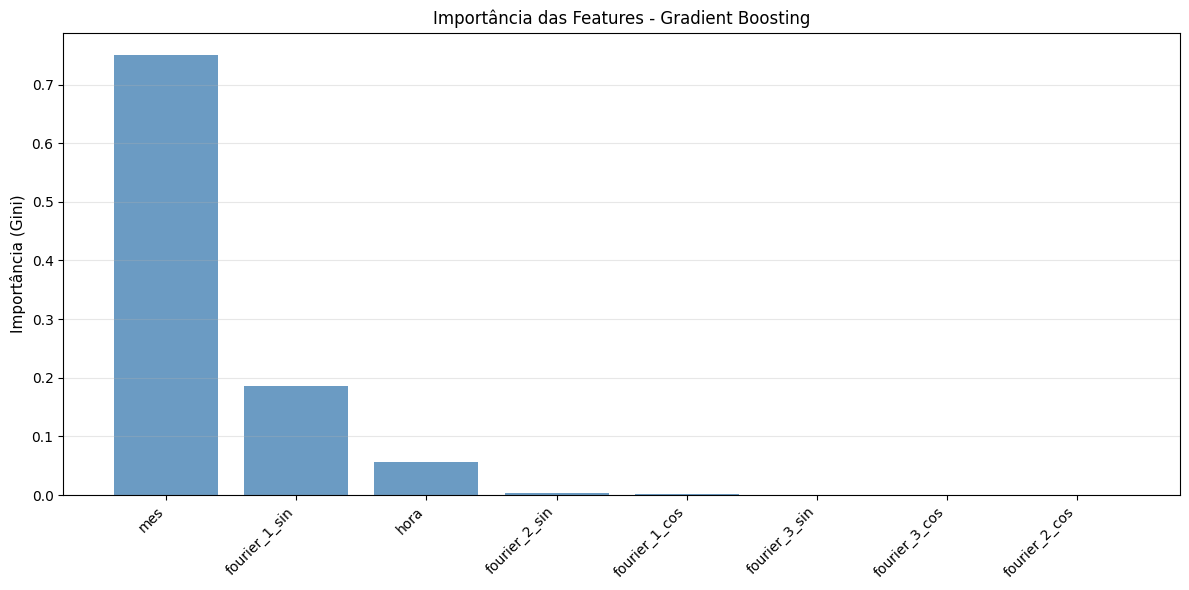


=== RESUMO FINAL DA AVALIAÇÃO NO TESTE ===

Modelo Selecionado: Gradient Boosting
Melhor n_splits: 5

Desempenho na VALIDAÇÃO (TimeSeriesSplit):
  RMSE:  3.5360 ± 0.6453
  R2:    0.3829 ± 0.2038
  MAE:   2.8039
  MAPE:  18.27%

Desempenho no TESTE (1-step ahead):
  RMSE:  4.1296
  R2:    0.5486
  MAE:   3.2503
  MAPE:  17.95%

Intervalos de Previsão (95% empírico):
  Coverage:        0.8879
  Largura média:   13.1002

Melhores Hiperparâmetros:
  model__learning_rate: 0.1370204442119109
  model__max_depth: 2
  model__min_samples_leaf: 8
  model__min_samples_split: 89
  model__n_estimators: 112
  model__subsample: 0.9077307142274171


In [26]:
# --- Avaliação no Conjunto de Teste (usando o melhor modelo da tunagem) ---
print("\n=== 6. AVALIAÇÃO NO CONJUNTO DE TESTE ===")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Selecionar o melhor modelo geral (aquele com menor RMSE na validação)
best_model_overall = None
best_model_name = None
best_metrics = None

best_rmse_overall = np.inf
for model_name, config in best_per_model.items():
    if config['metrics']['rmse_mean'] < best_rmse_overall:
        best_rmse_overall = config['metrics']['rmse_mean']
        best_model_overall = config['best_model']
        best_model_name = model_name
        best_metrics = config['metrics']

print(f"\n>>> MODELO SELECIONADO PARA TESTE: {best_model_name}")
print(f">>> RMSE (validação): {best_metrics['rmse_mean']:.4f} ± {best_metrics['rmse_std']:.4f}")
print(f">>> R2 (validação):   {best_metrics['r2_mean']:.4f} ± {best_metrics['r2_std']:.4f}")
print(f">>> Configuração: n_splits={best_per_model[best_model_name]['n_splits']}")

# --- Previsão no Conjunto de Teste (1-step ahead) ---
print(f"\n--- Avaliação 1-step ahead no Teste ---")
y_test_pred = best_model_overall.predict(X_test)
y_test_true = y_test.values

# Calcular métricas no teste
rmse_test = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
mae_test = mean_absolute_error(y_test_true, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test_true, y_test_pred) * 100
r2_test = r2_score(y_test_true, y_test_pred)

print(f"RMSE (Teste):   {rmse_test:.4f}")
print(f"MAE (Teste):    {mae_test:.4f}")
print(f"MAPE (Teste):   {mape_test:.2f}%")
print(f"R2 (Teste):     {r2_test:.4f}")

# --- Cálculo de Intervalo de Previsão Empírico (se apropriado) ---
if pi_precheck['allow_empirical_pi']:
    # Calcular resíduos na validação (X_combined e y_combined contêm treino+validação)
    y_combined_pred = best_model_overall.predict(X_combined)
    residuals = y_combined - y_combined_pred
    
    # Quantis empíricos dos resíduos (95%)
    lower_q = np.percentile(residuals, 2.5)
    upper_q = np.percentile(residuals, 97.5)
    
    print(f"\nIntervalos de Previsão Empíricos (95%):")
    print(f"  Quantil inferior (2.5%): {lower_q:.4f}")
    print(f"  Quantil superior (97.5%): {upper_q:.4f}")
    
    # Aplicar ao teste
    lower_test = y_test_pred + lower_q
    upper_test = y_test_pred + upper_q
    coverage_test = np.mean((y_test_true >= lower_test) & (y_test_true <= upper_test))
    mean_width_test = np.mean(upper_test - lower_test)
    
    print(f"  Coverage (Teste): {coverage_test:.4f}")
    print(f"  Largura média do PI: {mean_width_test:.4f}")
    
    use_pi = True
else:
    print(f"\nIntervalos de Previsão Empíricos: NÃO RECOMENDADOS")
    print(f"Motivos: {', '.join(pi_precheck['reasons'])}")
    use_pi = False

# --- Gráfico 1: Real vs Previsto (Scatter) ---
plt.figure(figsize=(10, 8))
plt.scatter(y_test_true, y_test_pred, alpha=0.5, s=20, color='teal', label='Previsões')
min_val = min(y_test_true.min(), y_test_pred.min())
max_val = max(y_test_true.max(), y_test_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Ideal (Perfeito)')
plt.xlabel('Temperatura Real (°C)', fontsize=12)
plt.ylabel('Temperatura Prevista (°C)', fontsize=12)
plt.title(f'Real vs Previsto - {best_model_name} (Teste)\nR² = {r2_test:.4f}, RMSE = {rmse_test:.4f}', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Gráfico 2: Série Temporal com Previsões e PI (se aplicável) ---
plt.figure(figsize=(16, 6))
plt.plot(y_test.index, y_test.values, label='Real (Teste)', color='black', linewidth=2, alpha=0.8)
plt.plot(y_test.index, y_test_pred, label=f'Previsto ({best_model_name})', linestyle='--', linewidth=1.5, color='blue', alpha=0.7)

if use_pi:
    plt.fill_between(y_test.index, lower_test, upper_test, color='orange', alpha=0.2, label='PI 95% (empírico)')

plt.xlabel('Data/Hora', fontsize=12)
plt.ylabel('Temperatura (°C)', fontsize=12)
plt.title(f'Previsão no Teste - {best_model_name}\nCobertura PI: {coverage_test:.4f}', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Gráfico 3: Resíduos no Teste ---
residuals_test = y_test_true - y_test_pred
plt.figure(figsize=(14, 5))

# Subplot 1: Resíduos ao longo do tempo
plt.subplot(1, 2, 1)
plt.plot(y_test.index, residuals_test, color='purple', linewidth=0.8, alpha=0.7)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Data/Hora', fontsize=11)
plt.ylabel('Resíduos (Real - Previsto)', fontsize=11)
plt.title('Resíduos ao Longo do Tempo', fontsize=11)
plt.grid(True, alpha=0.3)

# Subplot 2: Distribuição dos resíduos
plt.subplot(1, 2, 2)
plt.hist(residuals_test, bins=50, color='green', alpha=0.7, edgecolor='black')
plt.xlabel('Resíduos', fontsize=11)
plt.ylabel('Frequência', fontsize=11)
plt.title(f'Distribuição dos Resíduos\nMédia: {residuals_test.mean():.4f}, Std: {residuals_test.std():.4f}', fontsize=11)
plt.axvline(residuals_test.mean(), color='red', linestyle='--', linewidth=2, label=f'Média: {residuals_test.mean():.4f}')
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# --- Gráfico 4: Importância das Features (se o modelo suporta) ---
plt.figure(figsize=(12, 6))

if hasattr(best_model_overall.named_steps['model'], 'feature_importances_'):
    importances = best_model_overall.named_steps['model'].feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_names = X_test.columns.tolist()
    
    plt.bar(range(len(feature_names)), importances[indices], color='steelblue', alpha=0.8)
    plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=45, ha='right')
    plt.ylabel('Importância (Gini)', fontsize=11)
    plt.title(f'Importância das Features - {best_model_name}', fontsize=12)
    plt.grid(True, alpha=0.3, axis='y')
    
elif hasattr(best_model_overall.named_steps['model'], 'coef_'):
    coef = best_model_overall.named_steps['model'].coef_
    if coef.ndim > 1:
        coef = coef.flatten()
    indices = np.argsort(np.abs(coef))[::-1]
    feature_names = X_test.columns.tolist()
    colors = ['blue' if coef[i] > 0 else 'red' for i in indices]
    
    plt.bar(range(len(feature_names)), coef[indices], color=colors, alpha=0.7)
    plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=45, ha='right')
    plt.ylabel('Coeficiente', fontsize=11)
    plt.title(f'Impacto das Features - {best_model_name}', fontsize=12)
    plt.axhline(0, color='black', linewidth=0.8)
    plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# --- Resumo Final ---
print('\n' + '='*80)
print('=== RESUMO FINAL DA AVALIAÇÃO NO TESTE ===')
print('='*80)
print(f"\nModelo Selecionado: {best_model_name}")
print(f"Melhor n_splits: {best_per_model[best_model_name]['n_splits']}")
print(f"\nDesempenho na VALIDAÇÃO (TimeSeriesSplit):")
print(f"  RMSE:  {best_metrics['rmse_mean']:.4f} ± {best_metrics['rmse_std']:.4f}")
print(f"  R2:    {best_metrics['r2_mean']:.4f} ± {best_metrics['r2_std']:.4f}")
print(f"  MAE:   {best_metrics['mae_mean']:.4f}")
print(f"  MAPE:  {best_metrics['mape_mean']:.2f}%")
print(f"\nDesempenho no TESTE (1-step ahead):")
print(f"  RMSE:  {rmse_test:.4f}")
print(f"  R2:    {r2_test:.4f}")
print(f"  MAE:   {mae_test:.4f}")
print(f"  MAPE:  {mape_test:.2f}%")

if use_pi:
    print(f"\nIntervalos de Previsão (95% empírico):")
    print(f"  Coverage:        {coverage_test:.4f}")
    print(f"  Largura média:   {mean_width_test:.4f}")

print(f"\nMelhores Hiperparâmetros:")
for param, value in best_per_model[best_model_name]['best_params'].items():
    print(f"  {param}: {value}")
print('='*80)
